# Feature Engineering



Prepare features for two machine learning tasks:
1. Regression model
2. Classification model
3. Compare and select the best machine learning path

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* generate a list with variables to engineer

## Change working directory

In [1]:
import os


current_dir = os.getcwd()
current_dir

'/workspaces/Approval_Predict/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Approval_Predict'

## Load Data
Load the train and test sets from the cleaned outputs folder.

In [4]:
import pandas as pd


train_set = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")
train_set.head(3)

,income,credit_score,loan_amount,years_employed,points,loan_approved,loan_to_income
0,49973,464,22397,24,25.0,False,0.448182
1,70306,508,22644,5,35.0,False,0.322078
2,88446,798,17896,21,85.0,True,0.202338


In [5]:
test_set = pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv")
test_set.head(3)

,income,credit_score,loan_amount,years_employed,points,loan_approved,loan_to_income
0,130290,447,16496,10,55.0,False,0.126610
1,54050,808,10217,21,85.0,True,0.189029
2,105529,698,32169,35,75.0,True,0.304836


## Data Exploration

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=train_set, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Income and loan_amount have a wide range and loan_to_income have significant outliers.

https://www.geeksforgeeks.org/machine-learning/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/ 

RobustScaler reduces the impact of outliers by scaling data using median and interquartile range (IQR) and maintaining the data's shape. The other techinues may be sensitive to outliers and can distort scaling.

In [7]:
train_set[['income', 'credit_score', 'loan_amount', 'years_employed', 'points', 'loan_to_income']].agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
income,-0.009895,-1.199972
credit_score,0.004140,-1.257529
loan_amount,-0.006864,-1.191941
years_employed,-0.045962,-1.183605
points,0.231814,-0.602404
loan_to_income,1.434712,2.213330


From the dataframe above the loan_to_income has few large values (skew 1.43) and more extreme outliers (Kurtosis 2.21). Therefore, a Yeo-Johnson transform can be used on the loan_to_income variable to improve the performance of both regression and classification.

In [ ]:
%matplotlib inline
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

def FeatureEngineerAnalysis(df, analysis_type=None):
    """
    For quick feature engineering on numerical variables
    to decide which transformation can better transform the distribution shape
    by perform exploratory feature engineering transformations on selected numeric variables.
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions.

    """
    allowed_types = ['numerical', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feature_engineered = pd.DataFrame([])
    for column in df.columns:

        df_feature_engineered[column] = df[column].copy()
        for method in list_column_transformers:
            df_feature_engineered[f"{column}_{method}"] = df[column].copy()

        df_feature_engineered, list_applied_transformers = apply_transformers(
            analysis_type, df_feature_engineered, column
        )

        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feature_engineered
        )

    return df_feature_engineered

def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "reciprocal", "box_cox", "yeo_johnson"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feature_engineered, column):
    """
    Apply selected transformation types to a single column.
    """
    for col in df_feature_engineered.select_dtypes(include='category').columns:
        df_feature_engineered[col] = df_feature_engineered[col].astype('object')

    if analysis_type == 'numerical':
        df_feature_engineered, list_applied_transformers = FeatEngineering_Numerical(
            df_feature_engineered, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feature_engineered, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feature_engineered, column)

    return df_feature_engineered, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feature_engineered):
    """
    Display diagnostic visual evaluation for each transformed version of a column.
    """
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")

    cols_to_plot = [
        c for c in [column] + list_applied_transformers
        if c in df_feature_engineered.columns
    ]

    for col in cols_to_plot:
        DiagnosticPlots_Numerical(df_feature_engineered, col)


def DiagnosticPlots_Numerical(df, variable):
    """
    Produce diagnostic visual plots to assess distribution and normality.
    """
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

    return


def FeatEngineering_OutlierWinsorizer(df_feature_engineered, column):
    """
    Apply IQR-based Winsorizer to cap outlier values for a specific column.
    """
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feature_engineered = disc.fit_transform(df_feature_engineered)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feature_engineered.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feature_engineered, list_methods_worked


def FeatEngineering_Numerical(df_feature_engineered, column):
    """
    Apply mathematical transformations to normalize distribution shape.
    """
    list_methods_worked = []

    # Transformations mapped to names
    transformers = {
        "reciprocal": vt.ReciprocalTransformer,
        "box_cox": vt.BoxCoxTransformer,
        "yeo_johnson": vt.YeoJohnsonTransformer
    }

    for method, transformer in transformers.items():
        new_col = f"{column}_{method}"
        try:
            df_temp = df_feature_engineered.copy()
            df_temp[new_col] = df_temp[column]

            tr = transformer(variables=[new_col])
            df_temp = tr.fit_transform(df_temp)

            df_feature_engineered[new_col] = df_temp[new_col]
            list_methods_worked.append(new_col)

        except Exception:
            if new_col in df_feature_engineered.columns:
                df_feature_engineered.drop([new_col], axis=1, inplace=True)

    return df_feature_engineered, list_methods_worked

* Variable Analyzed: points
* Applied transformation: ['points_reciprocal', 'points_box_cox', 'points_yeo_johnson'] 



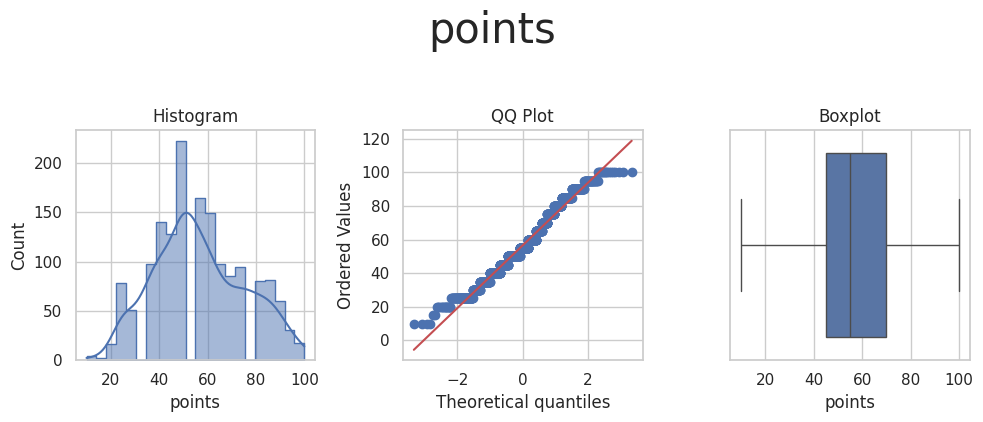

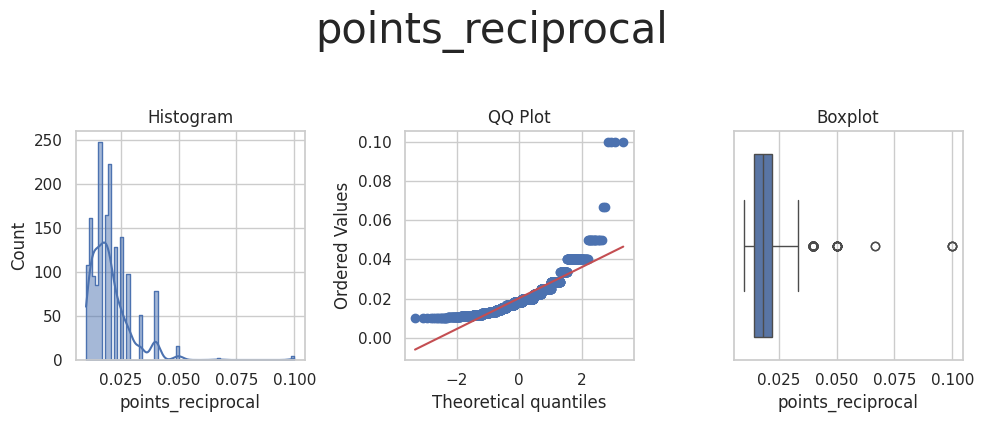

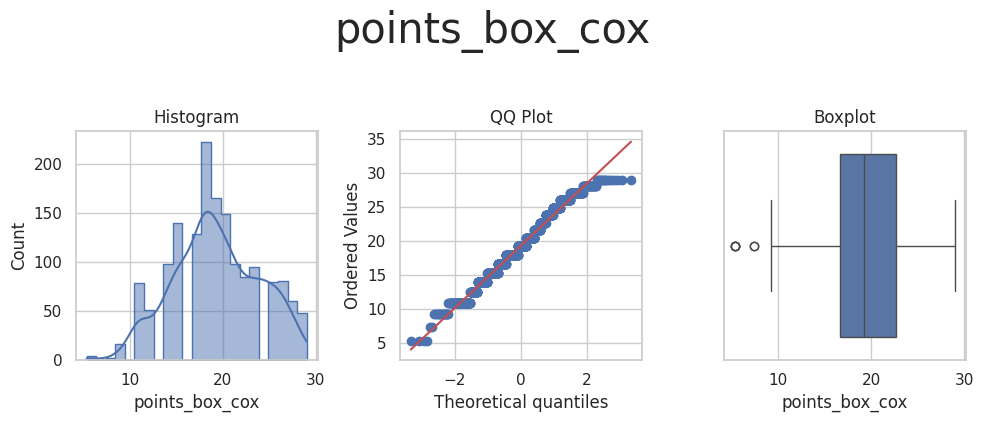

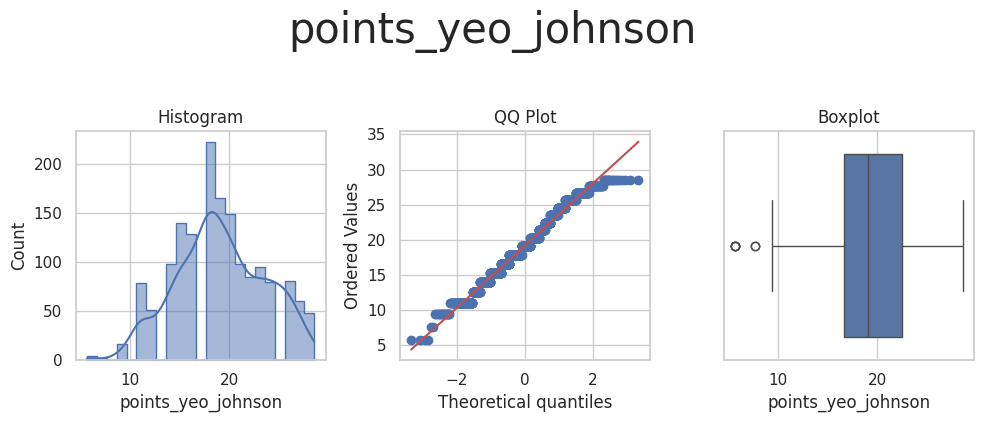

* Variable Analyzed: credit_score
* Applied transformation: ['credit_score_reciprocal', 'credit_score_box_cox', 'credit_score_yeo_johnson'] 



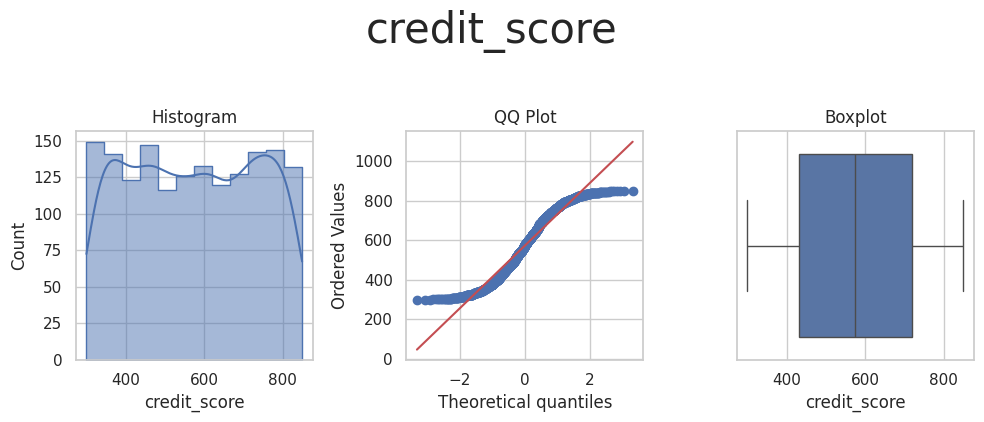

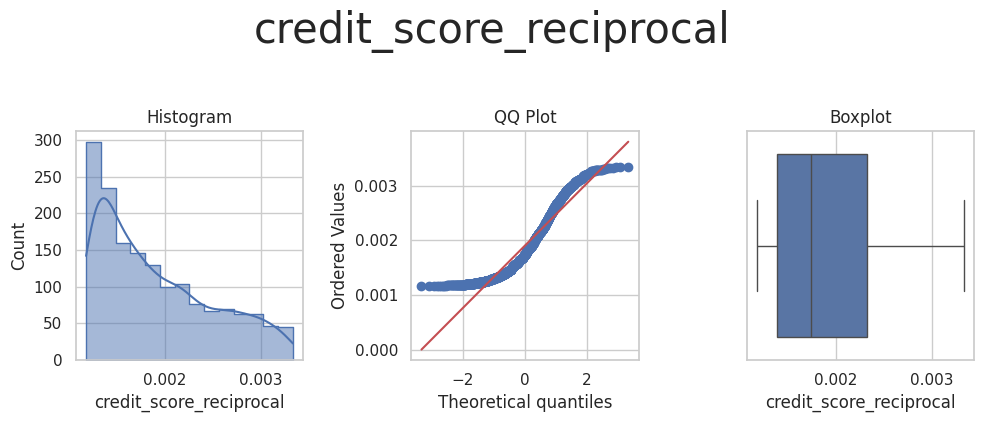

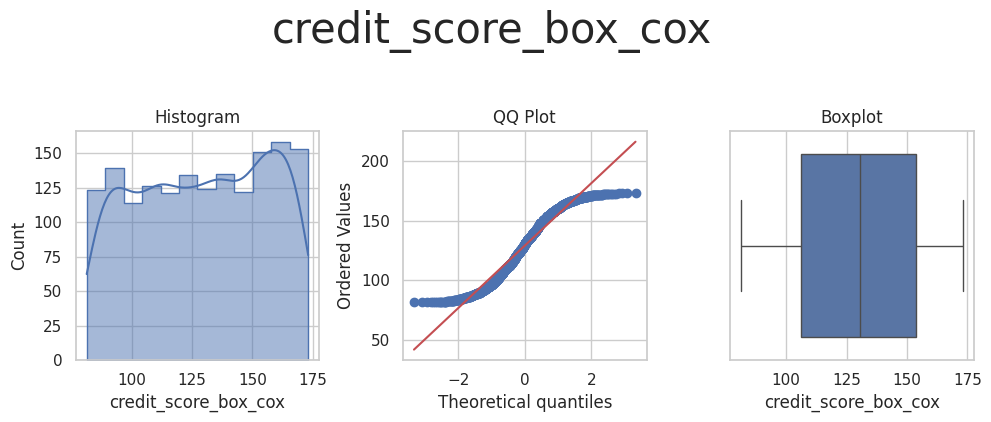

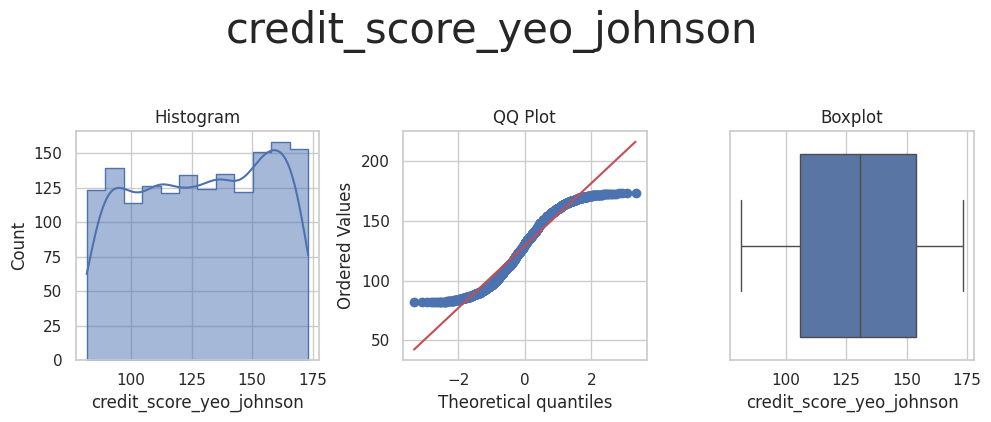

* Variable Analyzed: loan_to_income
* Applied transformation: ['loan_to_income_reciprocal', 'loan_to_income_box_cox', 'loan_to_income_yeo_johnson'] 



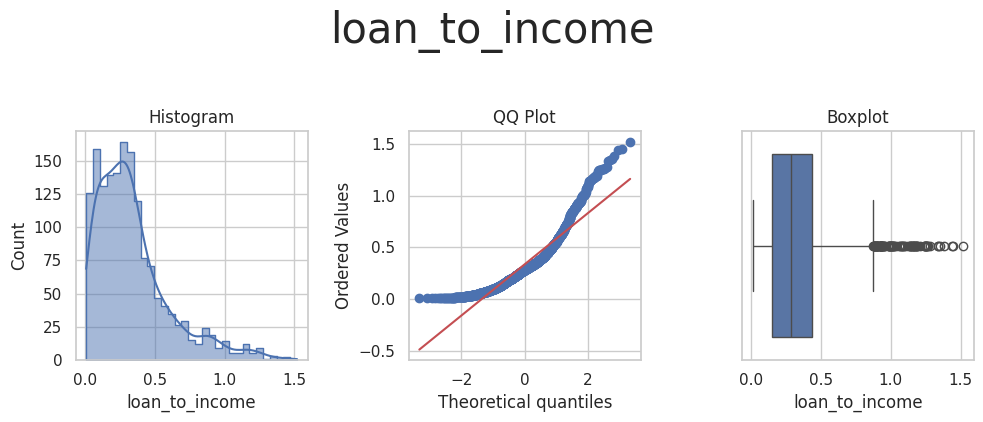

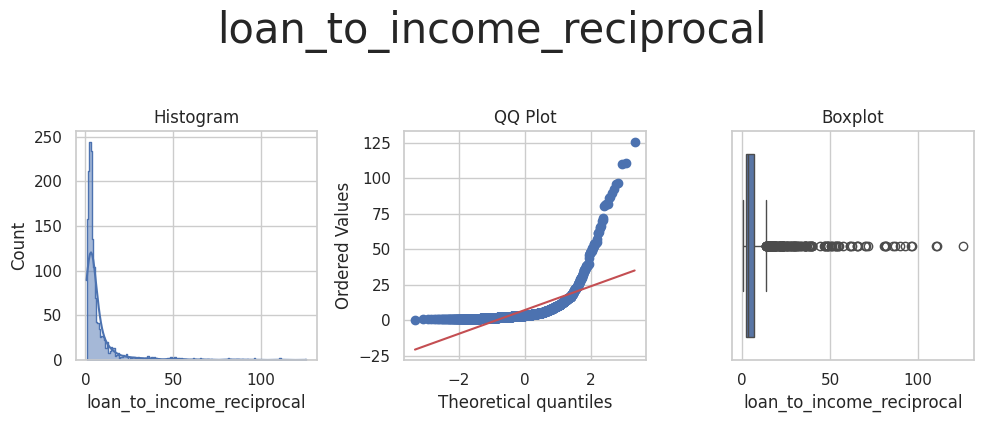

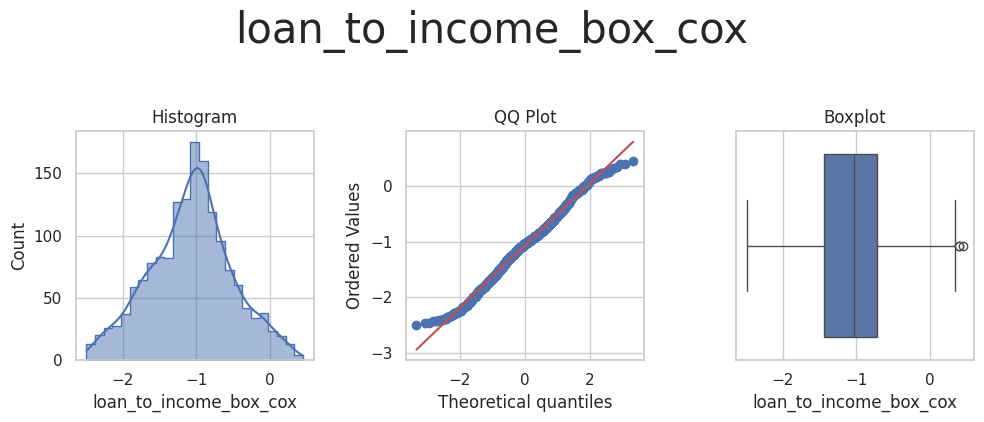

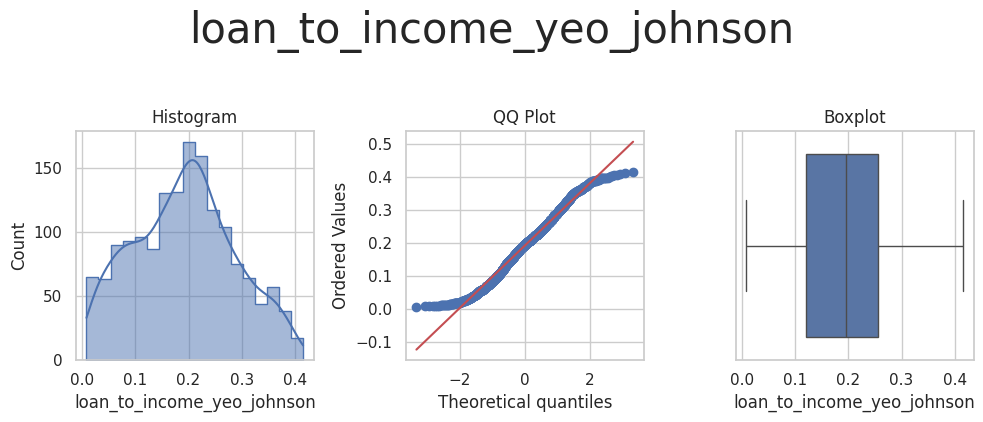

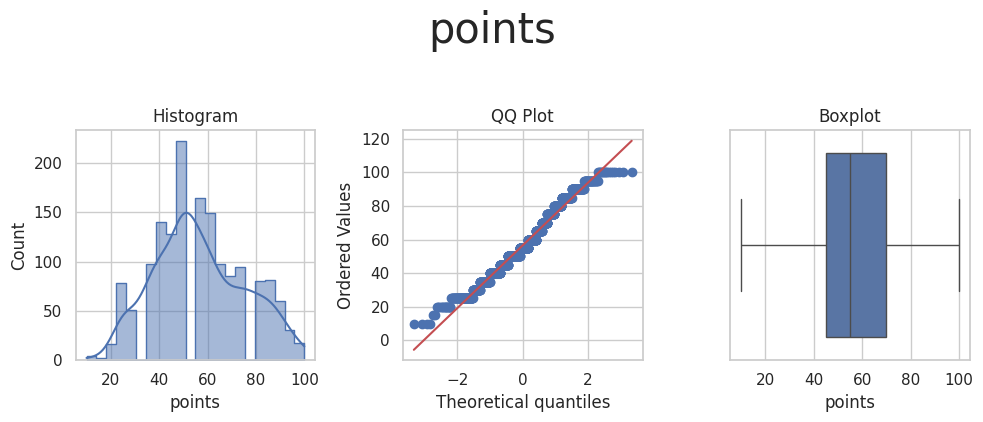

In [11]:
selected_features = ["points", "credit_score", "loan_to_income"]
engineered_df = FeatureEngineerAnalysis(train_set[selected_features], analysis_type='numerical')
DiagnosticPlots_Numerical(engineered_df, 'points')
